<a href="https://colab.research.google.com/github/Tanishq-Mehta-1/LULC-EUROSAT/blob/main/LULC_EUROSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as T

In [3]:
#importing EUROSAT DATA

train_transform = T.Compose([
    T.Resize((64,64)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(64,64), scale=(0.8,1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = T.Compose([
    T.Resize((64,64)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

torch.manual_seed(42)

train_ds = torchvision.datasets.EuroSAT(
    root='./data',
    download=True,
    transform= train_transform
)

test_ds = torchvision.datasets.EuroSAT(
    root='./data',
    download=True,
    transform= test_transform
)

100%|██████████| 94.3M/94.3M [00:01<00:00, 65.6MB/s]


In [11]:
torch.manual_seed(42)

indices = torch.randperm(len(train_ds))

num_train = 22_000
num_valid = 1_000

train_idx = indices[:num_train]
test_idx  = indices[num_train:]

valid_idx = test_idx[:num_valid]
test_idx  = test_idx[num_valid:]

train_set = torch.utils.data.Subset(train_ds, train_idx)
valid_set = torch.utils.data.Subset(test_ds, valid_idx)
test_set  = torch.utils.data.Subset(test_ds, test_idx)


In [4]:
print(f"Total Images: {len(train_ds)}")
print(f"Classes: {train_ds.classes}")

Total Images: 27000
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [12]:
def imshow_norm(image, ax):
  img = image.permute(1,2,0) #CHW -> HWC

  mean = torch.Tensor([0.485, 0.456, 0.406])
  std = torch.Tensor([0.229, 0.224, 0.225])
  img = std*img + mean

  img = np.clip(img, 0, 1)

  ax.imshow(img)
  ax.axis('off')


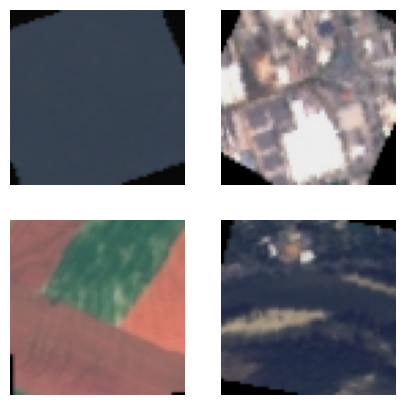

In [13]:
fig, ax = plt.subplots(2,2,figsize=(5,5))

np.random.seed(42)
id = np.random.randint(0, len(train_set)+1)
for i in range(2):
  for j in range(2):
    imshow_norm(train_set[id][0], ax[i][j])
    id = np.random.randint(0,27001)

In [16]:
#import resnet50

weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
resnet50 = torchvision.models.resnet50(weights=weights)

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)
valid_loader = DataLoader(valid_set, batch_size=32)

In [17]:
[name for name, child in resnet50.named_children()]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [19]:
class CustomModel(nn.Module):
  def __init__(self, resnet50):
    super().__init__()
    self.base = resnet50
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(resnet50.fc.in_features, len(train_ds.classes), bias=True),
    )
    self.base.fc = nn.Identity()

  def forward(self, X):
    features = self.base(X)
    logits = self.classifier(features)

    return logits

torch.manual_seed(42)
LULC_model = CustomModel(resnet50)


In [20]:
#freezing params

for param in LULC_model.base.parameters():
  param.requires_grad = False


In [21]:
def train(model, optimiser, scheduler, criterion, n_epochs):

    best_valid_acc = 0.0
    for epoch in range(n_epochs):
        model.train()
        train_loss, total_train, correct_train = 0.0, 0, 0

        for X_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
            X_train, y_train = X_train.to(device), y_train.to(device)

            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

            train_loss += loss.item() * y_train.size(0)
            _, predicted = torch.max(y_pred, 1)
            total_train += y_train.size(0)
            correct_train += (predicted == y_train).sum().item()

        model.eval()
        val_loss, total_val, correct_val = 0.0, 0, 0

        with torch.no_grad():
            for X, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]"):
                X, y = X.to(device), y.to(device)

                y_pr = model(X)
                loss = criterion(y_pr, y)

                val_loss += loss.item() * X.size(0)
                _, predicted = torch.max(y_pr, 1)
                total_val += y.size(0)
                correct_val += (predicted == y).sum().item()

        current_valid_acc = (correct_val / total_val) * 100
        scheduler.step()
        current_lr = optimiser.param_groups[0]['lr']

        if (current_valid_acc > best_valid_acc):
            best_valid_acc = current_valid_acc
            torch.save(model.state_dict(), f'best_lulc_model_{n_epochs}epochs.pth')
            print(f"New Best Val Acc: {best_valid_acc:.2f}%. Model Saved")

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {train_loss/total_train:.4f} | Train Acc: {100 * (correct_train/total_train):.2f}%")
        print(f"Val Loss: {val_loss/total_val:.4f} | Val Acc: {current_valid_acc:.2f}%")
        print(f"Current Learning Rate: {current_lr}\n")

In [22]:
import torch.optim as optim
from tqdm.auto import tqdm #progress bar

num_epochs=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LULC_model = LULC_model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(LULC_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=num_epochs,
    eta_min=1e-6,
)

In [ ]:
train(LULC_model, optimiser, scheduler, criterion, 30)

Epoch 1/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 80.80%. Model Saved

Epoch 1 Results:
Train Loss: 0.7312 | Train Acc: 75.47%
Val Loss: 0.5922 | Val Acc: 80.80%
Current Learning Rate: 3.4227024433899e-06



Epoch 2/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 80.90%. Model Saved

Epoch 2 Results:
Train Loss: 0.7333 | Train Acc: 76.13%
Val Loss: 0.5884 | Val Acc: 80.90%
Current Learning Rate: 1.0453658778440141e-05



Epoch 3/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 81.20%. Model Saved

Epoch 3 Results:
Train Loss: 0.7286 | Train Acc: 75.93%
Val Loss: 0.5785 | Val Acc: 81.20%
Current Learning Rate: 2.140463001152267e-05



Epoch 4/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 81.70%. Model Saved

Epoch 4 Results:
Train Loss: 0.7186 | Train Acc: 76.38%
Val Loss: 0.5706 | Val Acc: 81.70%
Current Learning Rate: 3.5203658778440255e-05



Epoch 5/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 81.90%. Model Saved

Epoch 5 Results:
Train Loss: 0.7161 | Train Acc: 76.38%
Val Loss: 0.5791 | Val Acc: 81.90%
Current Learning Rate: 5.050000000000022e-05



Epoch 6/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 6 Results:
Train Loss: 0.7147 | Train Acc: 76.69%
Val Loss: 0.5764 | Val Acc: 80.40%
Current Learning Rate: 6.579634122156018e-05



Epoch 7/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 7 Results:
Train Loss: 0.7108 | Train Acc: 76.31%
Val Loss: 0.5883 | Val Acc: 81.10%
Current Learning Rate: 7.959536998847776e-05



Epoch 8/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 8 Results:
Train Loss: 0.7043 | Train Acc: 76.29%
Val Loss: 0.5670 | Val Acc: 80.80%
Current Learning Rate: 9.054634122156031e-05



Epoch 9/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 82.40%. Model Saved

Epoch 9 Results:
Train Loss: 0.6886 | Train Acc: 77.15%
Val Loss: 0.5302 | Val Acc: 82.40%
Current Learning Rate: 9.757729755661054e-05



Epoch 10/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 10 Results:
Train Loss: 0.7002 | Train Acc: 76.53%
Val Loss: 0.5449 | Val Acc: 82.30%
Current Learning Rate: 0.00010000000000000044



Epoch 11/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 11 Results:
Train Loss: 0.6794 | Train Acc: 77.17%
Val Loss: 0.5795 | Val Acc: 80.20%
Current Learning Rate: 9.757729755661053e-05



Epoch 12/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 82.60%. Model Saved

Epoch 12 Results:
Train Loss: 0.6781 | Train Acc: 77.43%
Val Loss: 0.5286 | Val Acc: 82.60%
Current Learning Rate: 9.054634122156032e-05



Epoch 13/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 13 Results:
Train Loss: 0.6578 | Train Acc: 77.76%
Val Loss: 0.5717 | Val Acc: 80.50%
Current Learning Rate: 7.959536998847778e-05



Epoch 14/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 82.90%. Model Saved

Epoch 14 Results:
Train Loss: 0.6541 | Train Acc: 78.12%
Val Loss: 0.5142 | Val Acc: 82.90%
Current Learning Rate: 6.57963412215602e-05



Epoch 15/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 83.50%. Model Saved

Epoch 15 Results:
Train Loss: 0.6521 | Train Acc: 77.99%
Val Loss: 0.5044 | Val Acc: 83.50%
Current Learning Rate: 5.0500000000000225e-05



Epoch 16/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 16 Results:
Train Loss: 0.6434 | Train Acc: 78.24%
Val Loss: 0.5660 | Val Acc: 80.50%
Current Learning Rate: 3.520365877844027e-05



Epoch 17/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 17 Results:
Train Loss: 0.6580 | Train Acc: 77.69%
Val Loss: 0.5569 | Val Acc: 81.70%
Current Learning Rate: 2.1404630011522684e-05



Epoch 18/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 18 Results:
Train Loss: 0.6438 | Train Acc: 78.33%
Val Loss: 0.5473 | Val Acc: 82.50%
Current Learning Rate: 1.0453658778440156e-05



Epoch 19/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 19 Results:
Train Loss: 0.6446 | Train Acc: 78.32%
Val Loss: 0.5004 | Val Acc: 83.50%
Current Learning Rate: 3.422702443389917e-06



Epoch 20/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 20 Results:
Train Loss: 0.6391 | Train Acc: 78.57%
Val Loss: 0.5213 | Val Acc: 83.20%
Current Learning Rate: 1e-06



Epoch 21/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 84.50%. Model Saved

Epoch 21 Results:
Train Loss: 0.6443 | Train Acc: 78.22%
Val Loss: 0.4859 | Val Acc: 84.50%
Current Learning Rate: 3.4227024433899e-06



Epoch 22/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

New Best Val Acc: 85.30%. Model Saved

Epoch 22 Results:
Train Loss: 0.6335 | Train Acc: 78.60%
Val Loss: 0.4712 | Val Acc: 85.30%
Current Learning Rate: 1.0453658778440114e-05



Epoch 23/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 23 Results:
Train Loss: 0.6429 | Train Acc: 78.38%
Val Loss: 0.5034 | Val Acc: 83.20%
Current Learning Rate: 2.1404630011522613e-05



Epoch 24/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 24 Results:
Train Loss: 0.6434 | Train Acc: 78.55%
Val Loss: 0.4810 | Val Acc: 84.60%
Current Learning Rate: 3.520365877844016e-05



Epoch 25/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 25 Results:
Train Loss: 0.6383 | Train Acc: 78.54%
Val Loss: 0.5067 | Val Acc: 83.40%
Current Learning Rate: 5.0500000000000096e-05



Epoch 26/30 [Train]:   0%|          | 0/688 [00:00<?, ?it/s]

In [ ]:
LULC_model.load_state_dict(torch.load(f"best_lulc_model_{num_epochs}epochs.pth"))

In [29]:
def evaluate(model, criterion, test_loader):
    model.eval()
    test_loss, total, correct = 0.0, 0, 0

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Evaluating"):
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            test_loss += loss.item() * y.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_loss:.4f} | Test Acc: {accuracy:.2f}%")
    return avg_loss, accuracy

In [30]:
evaluate(LULC_model, criterion, test_loader)

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Test Loss: 0.5879 | Test Acc: 80.85%


(0.5878805410861969, 80.85)